In [1]:
import pandas as pd
import numpy as np
import time as tm
import copy

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from s_dbw import S_Dbw
from sklearn.cluster import MeanShift

from matplotlib import pyplot

In [2]:
data_loc = 'us'
file = f'../dataset/{data_loc}.csv' # choose the file want to read

df = pd.read_csv(file)  # read csv
df = pd.DataFrame(df) # trans into dataframe

time_start = tm.time() #開始計時

ip_time = dict()
special_chr = ["{", "}", "'", ":", " "]

for i in range(len(df)):
    raw_points = df['transactionList'][i]
    points = ''.join(e for e in raw_points if e not in special_chr)
    points = points.split(",")
    for j in range(len(points)):
        time = points[j][:17]
        ip = points[j][17:]
        if ip not in ip_time:
            ip_time[ip] = [time]
        else:
            ip_time[ip].append(time)

total_num = len(ip_time)
print(f'num of total server: {total_num}')
time_end = tm.time()
time_c = time_end - time_start
print(f'time cost: {time_c} seconds') # about (sec)
print(f'the size of data {len(df)}')

C:\Users\smart\AppData\Local\Temp\ipykernel_4024\2365690274.py:4: DtypeWarning: Columns (1,5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)  # read csv


num of total server: 619
time cost: 44.88454461097717 seconds
the size of data 284249


In [3]:
# dataset pre-processing

def get_ip_time(ip_data=ip_time, period='2021', period_ip_time=None): # period_ip_time: use to accumulate date
    if period_ip_time is None:
        period_ip_time = dict()
    if type(period) == str:
        len_p = len(period)
        for ip in ip_data:
            for time in ip_data[ip]:
                if time[0:len_p] == period:
                    if ip not in period_ip_time:
                        period_ip_time[ip] = [time]
                    else:
                        period_ip_time[ip] += [time]
    elif type(period) == list: #[time_1, time_2, ...]
        period_ip_time = get_ip_time(period=period[0])
        for time_i in period[1:]:
            period_ip_time = get_ip_time(period=time_i, period_ip_time=period_ip_time)
    return period_ip_time

data_2021 = get_ip_time(period='2021')

print('data_2021')
for key, value in data_2021.items():
    print(key)
    print(f'first 5 transaction: {value[0:5]}, \nlast 5 transaction: {value[-5:]}')
    print(f'transaction count: {len(value)}')
    break

data_2021
52.223.228.27
first 5 transaction: ['2021-04-13T181045', '2021-04-13T182747', '2021-04-13T183337', '2021-04-13T185612', '2021-04-13T194236'], 
last 5 transaction: ['2021-05-17T024051', '2021-05-17T051528', '2021-05-17T052856', '2021-05-17T053835', '2021-05-17T055112']
transaction count: 55337


In [4]:
# generate the accumulated data of each date - data_list
date_list = []
for ip in data_2021:
    for time in data_2021[ip]:
        date = time[:10]
        if date not in date_list:
            date_list.append(date)
            
data_list_dic = dict()
data_list_dic[date_list[0]] = get_ip_time(period=date_list[0])

for i in range(1, len(date_list)):
    print(f'{date_list[i]}')
    new_data = get_ip_time(period=date_list[i], period_ip_time=data_list_dic[date_list[i-1]])
    data_list_dic[date_list[i]] = copy.deepcopy(new_data)
# reason use deepcopy: https://www.jianshu.com/p/f1c623a4e21d

2021-04-14
2021-04-15
2021-04-16
2021-04-17
2021-04-18
2021-04-19
2021-04-20
2021-04-21
2021-04-22
2021-04-23
2021-04-24
2021-04-28
2021-04-29
2021-04-30
2021-05-01
2021-05-02
2021-05-03
2021-05-04
2021-05-05
2021-05-06
2021-05-07
2021-05-08
2021-05-09
2021-05-10
2021-05-11
2021-05-12
2021-05-13
2021-05-14
2021-05-15
2021-05-16
2021-05-17


In [5]:
# setup the dataset of below code
data_ip_time = data_2021

# setup hour axis for below chart
hour_axis = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

In [6]:
def kmeans_cluster(model, n_clusters=2, pca_components=False, plot=False, show_centers=False):
    if(pca_components):
        pca = PCA(n_components=pca_components).fit(model)
        model = pca.transform(model)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,
             random_state=0,
             batch_size=6,
             max_iter=10).fit(model)
    yhat = kmeans.predict(model)
    if(show_centers):print(kmeans.cluster_centers_)
    if(plot):
        pyplot.title(f'kmeans-cluster: {n_clusters}, pca: {bool(pca_components)}')
        if type(plot) == list:
            pyplot.xlabel(plot[0])
            pyplot.ylabel(plot[1])
        clusters = np.unique(yhat)
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            pyplot.scatter(model[row_ix, 0], model[row_ix, 1])
        pyplot.show()
    score = S_Dbw(model, yhat)
    return yhat, score # len(yhat) = num of ip

In [7]:
def mean_shift_cluster(model, pca_components=False, plot=False):
    if(pca_components):
        pca = PCA(n_components=pca_components).fit(model)
        model = pca.transform(model)
    clustering = MeanShift().fit(model)
    yhat = clustering.labels_
    clusters = np.unique(yhat)
    print(f'n_cluster: {len(clusters)}')
    score = S_Dbw(model, yhat)
    print(f'S_Dbw: {score}\n')
    if (plot):
        fig = pyplot.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel(f'{hour_period[0][0]}~{hour_period[0][-1]}')
        ax.set_ylabel(f'{hour_period[1][0]}~{hour_period[1][-1]}')
        ax.set_zlabel(f'{hour_period[2][0]}~{hour_period[2][-1]}')
        colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                  'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
        for cluster in clusters:
            row_ix = np.where(yhat == cluster)
            ax.scatter(model_3d[row_ix, 0], model_3d[row_ix, 1], model_3d[row_ix, 2], color=colors[cluster])
            print(f'class_{cluster}({colors[cluster][4:]}): {[round(np.mean(model_3d[row_ix, 0])), round(np.mean(model_3d[row_ix, 1])), round(np.mean(model_3d[row_ix, 2]))]}')
        pyplot.show()
    return yhat, score , len(clusters) # clustering result, S_Dbw Score, n_cluster

In [8]:
# get the 3-period features for each ip
hour_period = [] # ex: [['00'~'07'], ['08'~'15'], ['16'~'23']] 
def get_ip_periods_count(ip, ip_time=data_ip_time, hour_period=hour_period):
    hour_count = np.zeros((len(hour_period),), dtype=int)
    for time in ip_time[ip]: # hour = time[11:13]
        for i in range(len(hour_period)):
            if time[11:13] in hour_period[i]:
                hour_count[i] += 1
    return hour_count

In [9]:
s_dbw_every_date = [] # n_cluster = 2~8

In [10]:
n_periods = 3
slide_hour = 0
n_clusters = 2

s_dbw_every_date.append([])

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

for date in date_list:
    count_period3 = [] # [period1, period2, period3]
    ip_index = [] # [ip1, ip2, ..., ipn]
    for _ip in data_list_dic[date]:
        period3 = get_ip_periods_count(_ip, data_list_dic[date], hour_period)
        count_period3.append(period3)
        ip_index.append(_ip)
    X_count_hour3 = np.array(count_period3)

    yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=n_clusters, pca_components=2, plot=False, show_centers=False)
    s_dbw_every_date[-1].append(score_count_hour3)
    print(f'date: {date}, S_Dbw: {score_count_hour3}\n')


date: 2021-04-13, S_Dbw: 0.351477479641687

date: 2021-04-14, S_Dbw: 0.3562381950113607

date: 2021-04-15, S_Dbw: 0.34312985038811333

date: 2021-04-16, S_Dbw: 0.26369147782841873

date: 2021-04-17, S_Dbw: 0.2242365666355404

date: 2021-04-18, S_Dbw: 0.26324559384931606

date: 2021-04-19, S_Dbw: 0.19140496938526527

date: 2021-04-20, S_Dbw: 0.16180807417269563

date: 2021-04-21, S_Dbw: 0.1472070564989366

date: 2021-04-22, S_Dbw: 0.14786605755067633

date: 2021-04-23, S_Dbw: 0.15078292730773968

date: 2021-04-24, S_Dbw: 0.27170231716950427

date: 2021-04-28, S_Dbw: 0.42767920914676344

date: 2021-04-29, S_Dbw: 0.6008955274600606

date: 2021-04-30, S_Dbw: 0.6634155526201351

date: 2021-05-01, S_Dbw: 0.6309077340892377

date: 2021-05-02, S_Dbw: 0.5817070670057208

date: 2021-05-03, S_Dbw: 0.5428502232397482

date: 2021-05-04, S_Dbw: 0.5167127466906529

date: 2021-05-05, S_Dbw: 0.6175319607887502

date: 2021-05-06, S_Dbw: 0.5720333423271232

date: 2021-05-07, S_Dbw: 0.5434905271259798

da

In [11]:
n_periods = 3
slide_hour = 0
n_clusters = 3

s_dbw_every_date.append([])

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

for date in date_list:
    count_period3 = [] # [period1, period2, period3]
    ip_index = [] # [ip1, ip2, ..., ipn]
    for _ip in data_list_dic[date]:
        period3 = get_ip_periods_count(_ip, data_list_dic[date], hour_period)
        count_period3.append(period3)
        ip_index.append(_ip)
    X_count_hour3 = np.array(count_period3)

    yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=n_clusters, pca_components=2, plot=False, show_centers=False)
    s_dbw_every_date[-1].append(score_count_hour3)
    print(f'date: {date}, S_Dbw: {score_count_hour3}\n')


date: 2021-04-13, S_Dbw: 0.30019585944702376

date: 2021-04-14, S_Dbw: 0.2053761146468858

date: 2021-04-15, S_Dbw: 0.20460489058266337

date: 2021-04-16, S_Dbw: 0.18202639306134494

date: 2021-04-17, S_Dbw: 0.14813994049425383

date: 2021-04-18, S_Dbw: 0.2985879159272333

date: 2021-04-19, S_Dbw: 0.17280248758674532

date: 2021-04-20, S_Dbw: 0.15402418417649144

date: 2021-04-21, S_Dbw: 0.19376672429209726

date: 2021-04-22, S_Dbw: 0.1354295822828035

date: 2021-04-23, S_Dbw: 0.1354577343664941

date: 2021-04-24, S_Dbw: 0.20033552004874075

date: 2021-04-28, S_Dbw: 0.2885770428662301

date: 2021-04-29, S_Dbw: 0.4020387923094068

date: 2021-04-30, S_Dbw: 0.43818933699821816

date: 2021-05-01, S_Dbw: 0.42172588948747414

date: 2021-05-02, S_Dbw: 0.41286818955991034

date: 2021-05-03, S_Dbw: 0.40118254980145845

date: 2021-05-04, S_Dbw: 0.3775195071698491

date: 2021-05-05, S_Dbw: 0.5256103698523856

date: 2021-05-06, S_Dbw: 1.658595118922634

date: 2021-05-07, S_Dbw: 2.033695281865964



In [12]:
n_periods = 3
slide_hour = 0
n_clusters = 4

s_dbw_every_date.append([])

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

for date in date_list:
    count_period3 = [] # [period1, period2, period3]
    ip_index = [] # [ip1, ip2, ..., ipn]
    for _ip in data_list_dic[date]:
        period3 = get_ip_periods_count(_ip, data_list_dic[date], hour_period)
        count_period3.append(period3)
        ip_index.append(_ip)
    X_count_hour3 = np.array(count_period3)

    yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=n_clusters, pca_components=2, plot=False, show_centers=False)
    s_dbw_every_date[-1].append(score_count_hour3)
    print(f'date: {date}, S_Dbw: {score_count_hour3}\n')


date: 2021-04-13, S_Dbw: 0.24156270506742716

date: 2021-04-14, S_Dbw: 0.30744228184730205

date: 2021-04-15, S_Dbw: 0.23936308379986093

date: 2021-04-16, S_Dbw: 0.2072268964735408

date: 2021-04-17, S_Dbw: 0.14254634099165836

date: 2021-04-18, S_Dbw: 0.1902266040289194

date: 2021-04-19, S_Dbw: 0.20940197800487603

date: 2021-04-20, S_Dbw: 0.15436107990359416

date: 2021-04-21, S_Dbw: 0.1720182327064708

date: 2021-04-22, S_Dbw: 0.14692050009399737

date: 2021-04-23, S_Dbw: 0.10079905340492445

date: 2021-04-24, S_Dbw: 0.19474360394217782

date: 2021-04-28, S_Dbw: 0.2052588204559207

date: 2021-04-29, S_Dbw: 0.30018310178446955

date: 2021-04-30, S_Dbw: 0.3175482341046742

date: 2021-05-01, S_Dbw: 0.28350015130624073

date: 2021-05-02, S_Dbw: 0.2738136032617713

date: 2021-05-03, S_Dbw: 0.2627390549093617

date: 2021-05-04, S_Dbw: 0.26242852777069325

date: 2021-05-05, S_Dbw: 1.0895020400979567

date: 2021-05-06, S_Dbw: 0.31319263898604344

date: 2021-05-07, S_Dbw: 1.575410109350467

In [13]:
n_periods = 3
slide_hour = 0
n_clusters = 5

s_dbw_every_date.append([])

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

for date in date_list:
    count_period3 = [] # [period1, period2, period3]
    ip_index = [] # [ip1, ip2, ..., ipn]
    for _ip in data_list_dic[date]:
        period3 = get_ip_periods_count(_ip, data_list_dic[date], hour_period)
        count_period3.append(period3)
        ip_index.append(_ip)
    X_count_hour3 = np.array(count_period3)

    yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=n_clusters, pca_components=2, plot=False, show_centers=False)
    s_dbw_every_date[-1].append(score_count_hour3)
    print(f'date: {date}, S_Dbw: {score_count_hour3}\n')


date: 2021-04-13, S_Dbw: 0.151670630861243

date: 2021-04-14, S_Dbw: 0.14036491437723894

date: 2021-04-15, S_Dbw: 0.1555048442735747

date: 2021-04-16, S_Dbw: 0.26862789390068276

date: 2021-04-17, S_Dbw: 0.1247695934650839

date: 2021-04-18, S_Dbw: 0.13796524856717593

date: 2021-04-19, S_Dbw: 0.1948854803517662

date: 2021-04-20, S_Dbw: 0.0874154409196768

date: 2021-04-21, S_Dbw: 0.12515532478835228

date: 2021-04-22, S_Dbw: 0.12824694636141076

date: 2021-04-23, S_Dbw: 0.07789259459917641

date: 2021-04-24, S_Dbw: 0.12565515784852044

date: 2021-04-28, S_Dbw: 0.22128562875563

date: 2021-04-29, S_Dbw: 0.2430998643520578

date: 2021-04-30, S_Dbw: 0.2993739950414856

date: 2021-05-01, S_Dbw: 0.5031521417891825

date: 2021-05-02, S_Dbw: 0.3677532296024506

date: 2021-05-03, S_Dbw: 0.3631182617094188

date: 2021-05-04, S_Dbw: 0.34764730918411824

date: 2021-05-05, S_Dbw: 1.144554427041979

date: 2021-05-06, S_Dbw: 0.8792033286950844

date: 2021-05-07, S_Dbw: 0.4641835992047364

date: 

In [14]:
n_periods = 3
slide_hour = 0
n_clusters = 6

s_dbw_every_date.append([])

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

for date in date_list:
    count_period3 = [] # [period1, period2, period3]
    ip_index = [] # [ip1, ip2, ..., ipn]
    for _ip in data_list_dic[date]:
        period3 = get_ip_periods_count(_ip, data_list_dic[date], hour_period)
        count_period3.append(period3)
        ip_index.append(_ip)
    X_count_hour3 = np.array(count_period3)

    yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=n_clusters, pca_components=2, plot=False, show_centers=False)
    s_dbw_every_date[-1].append(score_count_hour3)
    print(f'date: {date}, S_Dbw: {score_count_hour3}\n')


date: 2021-04-13, S_Dbw: 0.10078021153134782

date: 2021-04-14, S_Dbw: 0.1856420968361544

date: 2021-04-15, S_Dbw: 0.18550731384693359

date: 2021-04-16, S_Dbw: 0.17170996217841966

date: 2021-04-17, S_Dbw: 0.09465690561867979

date: 2021-04-18, S_Dbw: 0.08558295102858181

date: 2021-04-19, S_Dbw: 0.19712093396197153

date: 2021-04-20, S_Dbw: 0.11688666038237283

date: 2021-04-21, S_Dbw: 0.18374954149760192

date: 2021-04-22, S_Dbw: 0.08615764031323744

date: 2021-04-23, S_Dbw: 0.1373332631938306

date: 2021-04-24, S_Dbw: 0.09058902836205349

date: 2021-04-28, S_Dbw: 0.14047206032222587

date: 2021-04-29, S_Dbw: 0.2757609782628112

date: 2021-04-30, S_Dbw: 0.24621740179933913

date: 2021-05-01, S_Dbw: 0.25558478303427834

date: 2021-05-02, S_Dbw: 0.20244068591212408

date: 2021-05-03, S_Dbw: 0.18738678879788498

date: 2021-05-04, S_Dbw: 0.21296802448802962

date: 2021-05-05, S_Dbw: 0.21717879337795873

date: 2021-05-06, S_Dbw: 0.3299890946699778

date: 2021-05-07, S_Dbw: 0.27408240227

In [15]:
n_periods = 3
slide_hour = 0
n_clusters = 7

s_dbw_every_date.append([])

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

for date in date_list:
    count_period3 = [] # [period1, period2, period3]
    ip_index = [] # [ip1, ip2, ..., ipn]
    for _ip in data_list_dic[date]:
        period3 = get_ip_periods_count(_ip, data_list_dic[date], hour_period)
        count_period3.append(period3)
        ip_index.append(_ip)
    X_count_hour3 = np.array(count_period3)

    yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=n_clusters, pca_components=2, plot=False, show_centers=False)
    s_dbw_every_date[-1].append(score_count_hour3)
    print(f'date: {date}, S_Dbw: {score_count_hour3}\n')


date: 2021-04-13, S_Dbw: 0.27401040585825687

date: 2021-04-14, S_Dbw: 0.19205372616129174

date: 2021-04-15, S_Dbw: 0.10318206558766684

date: 2021-04-16, S_Dbw: 0.14000747526866503

date: 2021-04-17, S_Dbw: 0.11753390188246546

date: 2021-04-18, S_Dbw: 0.10753613353823661

date: 2021-04-19, S_Dbw: 0.09722607559896901

date: 2021-04-20, S_Dbw: 0.12643849753708541

date: 2021-04-21, S_Dbw: 0.09064915088247855

date: 2021-04-22, S_Dbw: 0.08173185480480027

date: 2021-04-23, S_Dbw: 0.10150749880858395

date: 2021-04-24, S_Dbw: 0.1077855569038032

date: 2021-04-28, S_Dbw: 0.1294787885745284

date: 2021-04-29, S_Dbw: 0.14884007572072963

date: 2021-04-30, S_Dbw: 0.24773483579021013

date: 2021-05-01, S_Dbw: 0.22094861303768648

date: 2021-05-02, S_Dbw: 0.22479735899018155

date: 2021-05-03, S_Dbw: 0.16074833428678809

date: 2021-05-04, S_Dbw: 0.19494842023939332

date: 2021-05-05, S_Dbw: 0.5341135285343827

date: 2021-05-06, S_Dbw: 0.6238479349714158

date: 2021-05-07, S_Dbw: 0.62789281959

In [16]:
n_periods = 3
slide_hour = 0
n_clusters = 8

s_dbw_every_date.append([])

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

for date in date_list:
    count_period3 = [] # [period1, period2, period3]
    ip_index = [] # [ip1, ip2, ..., ipn]
    for _ip in data_list_dic[date]:
        period3 = get_ip_periods_count(_ip, data_list_dic[date], hour_period)
        count_period3.append(period3)
        ip_index.append(_ip)
    X_count_hour3 = np.array(count_period3)

    yhat_count_hour3, score_count_hour3 = kmeans_cluster(X_count_hour3, n_clusters=n_clusters, pca_components=2, plot=False, show_centers=False)
    s_dbw_every_date[-1].append(score_count_hour3)
    print(f'date: {date}, S_Dbw: {score_count_hour3}\n')


date: 2021-04-13, S_Dbw: 0.21912616543413782

date: 2021-04-14, S_Dbw: 0.22767781503833878

date: 2021-04-15, S_Dbw: 0.2135795001992311

date: 2021-04-16, S_Dbw: 0.10140433647562558

date: 2021-04-17, S_Dbw: 0.10942603717221547

date: 2021-04-18, S_Dbw: 0.10091427439489593

date: 2021-04-19, S_Dbw: 0.06281282235247085

date: 2021-04-20, S_Dbw: 0.1398113557491032

date: 2021-04-21, S_Dbw: 0.11716073153747322

date: 2021-04-22, S_Dbw: 0.07018656395560308

date: 2021-04-23, S_Dbw: 0.08645997643742626

date: 2021-04-24, S_Dbw: 0.11499028539623304

date: 2021-04-28, S_Dbw: 0.23301716290263938

date: 2021-04-29, S_Dbw: 0.1485664002575592

date: 2021-04-30, S_Dbw: 0.09931490211336534

date: 2021-05-01, S_Dbw: 0.13265098970064274

date: 2021-05-02, S_Dbw: 0.18482983677284653

date: 2021-05-03, S_Dbw: 0.22454871037583468

date: 2021-05-04, S_Dbw: 0.15121067252871614

date: 2021-05-05, S_Dbw: 0.13544380403636316

date: 2021-05-06, S_Dbw: 0.1928990597369688

date: 2021-05-07, S_Dbw: 0.82937030247

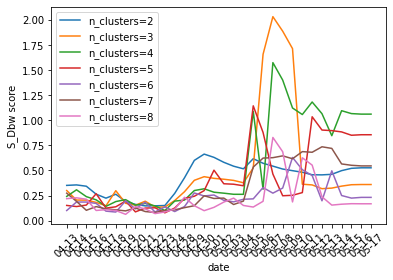

Figure 8.1: Online Clustering with K-Means - n_cluster= 2 to 8


In [17]:
# Figure 8.1: Online Clustering with K-Means - n_cluster= 2 to 8

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
            'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

pyplot.xlabel('date')
pyplot.xticks(rotation=45)
pyplot.ylabel('S_Dbw score')

x_axis = []
for date in date_list:
    x_axis.append(date[-5:])
n_clusters = 2
for scores in s_dbw_every_date:
    pyplot.plot(x_axis, scores, color=colors[n_clusters-2], label=f'n_clusters={n_clusters}')
    n_clusters += 1
pyplot.legend()
pyplot.show()

print('Figure 8.1: Online Clustering with K-Means - n_cluster= 2 to 8')

In [18]:
# plot s_dbw_every_date - Mean Shift

n_periods = 3
slide_hour = 0
n_clusters = 8

s_dbw_every_date_mean_shift = []
n_cluster_every_date_mean_shift = []

period_len = len(hour_axis)//n_periods
hour_period = []
for i in range(n_periods-1):
    hour_period.append(hour_axis[period_len*i + slide_hour:period_len*(i+1) + slide_hour])
hour_period.append(hour_axis[period_len*(n_periods-1) + slide_hour:] + hour_axis[:slide_hour])

for date in date_list:
    count_period3 = [] # [period1, period2, period3]
    ip_index = [] # [ip1, ip2, ..., ipn]
    for _ip in data_list_dic[date]:
        period3 = get_ip_periods_count(_ip, data_list_dic[date], hour_period)
        count_period3.append(period3)
        ip_index.append(_ip)
    X_count_hour3 = np.array(count_period3)
    yhat_count_hour3, score_count_hour3, n_cluster = mean_shift_cluster(X_count_hour3, pca_components=2, plot=False)
    s_dbw_every_date_mean_shift.append(score_count_hour3)
    n_cluster_every_date_mean_shift.append(n_cluster)

n_cluster: 4
S_Dbw: 0.0900514938135382

n_cluster: 4
S_Dbw: 0.44129540093759234

n_cluster: 6
S_Dbw: 0.05533127811943877

n_cluster: 4
S_Dbw: 0.1384432163995096

n_cluster: 4
S_Dbw: 0.12722830264627538

n_cluster: 4
S_Dbw: 0.1525749103270932

n_cluster: 3
S_Dbw: 0.17280248758674532

n_cluster: 3
S_Dbw: 0.15402418417649144

n_cluster: 3
S_Dbw: 0.19376672429209726

n_cluster: 3
S_Dbw: 0.1354295822828035

n_cluster: 3
S_Dbw: 0.1354577343664941

n_cluster: 4
S_Dbw: 0.1247305530290388

n_cluster: 5
S_Dbw: 0.1347208986999042

n_cluster: 4
S_Dbw: 0.15094485016476106

n_cluster: 6
S_Dbw: 0.07985088916506916

n_cluster: 6
S_Dbw: 0.07258138807943211

n_cluster: 6
S_Dbw: 0.06970462636839411

n_cluster: 6
S_Dbw: 0.06081875240308328

n_cluster: 6
S_Dbw: 0.05474463896344512

n_cluster: 6
S_Dbw: 0.06647009666987659

n_cluster: 6
S_Dbw: 0.07126142000835631

n_cluster: 7
S_Dbw: 0.07489165022964132

n_cluster: 7
S_Dbw: 0.0792180354978849

n_cluster: 7
S_Dbw: 0.08669277757243263

n_cluster: 7
S_Dbw: 0.09

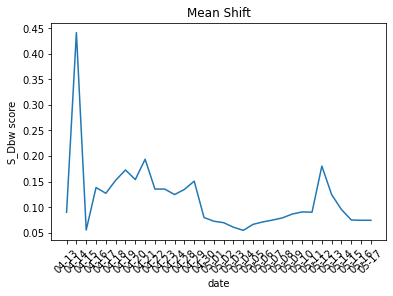

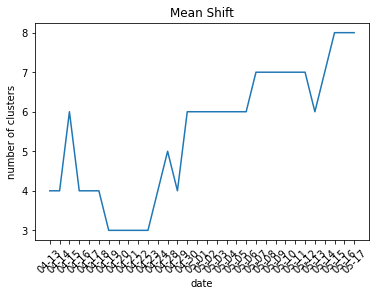

Figure 8.2: Online Clustering with Mean Shift


In [19]:
# Figure 8.2: Online Clustering with Mean Shift

pyplot.title('Mean Shift')
pyplot.xlabel('date')
pyplot.xticks(rotation=45)
pyplot.ylabel('S_Dbw score')

x_axis = []
for date in date_list:
    x_axis.append(date[-5:])

pyplot.plot(x_axis, s_dbw_every_date_mean_shift)
pyplot.show()

pyplot.title('Mean Shift')
pyplot.xlabel('date')
pyplot.xticks(rotation=45)
pyplot.ylabel('number of clusters')

x_axis = []
for date in date_list:
    x_axis.append(date[-5:])
pyplot.plot(x_axis, n_cluster_every_date_mean_shift)
pyplot.show()

print('Figure 8.2: Online Clustering with Mean Shift')